<a href="https://colab.research.google.com/github/AAA123404/Financial-big-data-analysis/blob/main/week9%E4%BD%9C%E6%A5%AD_%E6%99%82%E9%96%93%E5%BA%8F%E5%88%97_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance pandas numpy torch scikit-learn matplotlib

In [9]:
import numpy as np
import pandas as pd
import yfinance as yf
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import torch.optim as optim

In [10]:
tsmc = yf.download('2330.TW', start='2020-01-01')
tsmc

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,2330.TW,2330.TW,2330.TW,2330.TW,2330.TW,2330.TW
Date,,,,,,
2020-01-02 00:00:00+00:00,306.430145,339.0,339.0,332.5,332.5,31754120
2020-01-03 00:00:00+00:00,306.882172,339.5,345.0,335.5,344.0,41811268
2020-01-06 00:00:00+00:00,300.102661,332.0,334.5,332.0,333.0,45343057
2020-01-07 00:00:00+00:00,297.842896,329.5,333.0,326.5,332.5,50879181
2020-01-08 00:00:00+00:00,297.842896,329.5,333.0,325.0,325.0,37567748
...,...,...,...,...,...,...
2024-11-01 00:00:00+00:00,1025.000000,1025.0,1030.0,996.0,996.0,54480255
2024-11-04 00:00:00+00:00,1040.000000,1040.0,1045.0,1025.0,1030.0,26747978


In [54]:
def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_macd(df, fast_period=12, slow_period=26):
    df['EMA12'] = df['Close'].ewm(span=fast_period, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=slow_period, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    return df[['MACD']]


def create_features(df):
  df_feat = df.copy()
  df_feat['MA5'] = df_feat['Close'].rolling(window=5).mean()
  df_feat['MA20'] = df_feat['Close'].rolling(window=20).mean()
  df_feat['RSI'] = calculate_rsi(df_feat['Close'])
  df_feat['MACD'] = calculate_macd(df_feat)['MACD']
  df_feat = df_feat.dropna()
  return df_feat

df_features = create_features(tsmc)
df_features

Price,Adj Close,Close,High,Low,Open,Volume,MA5,MA20,RSI,EMA12,EMA26,MACD
Ticker,2330.TW,2330.TW,2330.TW,2330.TW,2330.TW,2330.TW,,,,,,
Date,,,,,,,,,,,,
2020-02-07 00:00:00+00:00,296.487000,328.0,330.5,326.0,330.0,28798327,325.6,331.950,43.065693,328.735034,331.952663,-3.217629
2020-02-10 00:00:00+00:00,296.035034,327.5,328.0,321.0,321.5,30632424,328.1,331.375,41.044776,328.545029,331.622836,-3.077807
2020-02-11 00:00:00+00:00,299.650696,331.5,332.5,330.0,330.5,27524935,329.4,330.975,42.753623,328.999640,331.613737,-2.614097
2020-02-12 00:00:00+00:00,302.814484,335.0,336.0,333.0,333.5,37612639,330.9,331.125,41.911765,329.922772,331.864571,-1.941799
2020-02-13 00:00:00+00:00,302.814484,335.0,338.0,335.0,338.0,22757021,331.4,331.400,45.967742,330.703884,332.096825,-1.392941
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-01 00:00:00+00:00,1025.000000,1025.0,1030.0,996.0,996.0,54480255,1035.0,1042.850,44.444444,1041.153095,1026.664151,14.488945
2024-11-04 00:00:00+00:00,1040.000000,1040.0,1045.0,1025.0,1030.0,26747978,1033.0,1046.000,41.176471,1040.975696,1027.651991,13.323705


In [55]:
feature_columns = ['MA5', 'MA20', 'RSI', 'MACD','Open', 'High', 'Low', 'Close']
X = df_features[feature_columns].values
y = df_features['Close'].shift(-1).values[:-1]
X = X[:-1]

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(X_scaled) * 0.8)

X_train = X_scaled[:train_size]
X_test = X_scaled[train_size-20:]
y_train = y_scaled[:train_size]
y_test = y_scaled[train_size-20:]

def create_sequences(X, y, sequence_length=20):
    sequences_X, sequences_y = [], []
    for i in range(len(X) - sequence_length):
        sequences_X.append(X[i:i+sequence_length])
        sequences_y.append(y[i + sequence_length])
    return np.array(sequences_X), np.array(sequences_y)

X_train_seq, y_train_seq = create_sequences(X_train, y_train)
X_test_seq, y_test_seq = create_sequences(X_test, y_test)


X_train_seq = torch.FloatTensor(X_train_seq)
y_train_seq = torch.FloatTensor(y_train_seq)
X_test_seq = torch.FloatTensor(X_test_seq)
y_test_seq = torch.FloatTensor(y_test_seq)


In [56]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = StockDataset(X_train, y_train)
test_dataset = StockDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [57]:
class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, output_size=1):
        super(StockLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        lstm_out, (hn, cn) = self.lstm(x)
        lstm_out_last = lstm_out[:, -1, :]
        lstm_out_last = self.dropout(lstm_out_last)
        output = self.fc(lstm_out_last)

        return output

In [58]:
input_size = len(feature_columns)
hidden_size = 64
num_layers = 2
output_size = 1

model = StockLSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)
outputs = model(X_train_seq)

In [59]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [60]:
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()  #
    outputs = model(X_train_seq)
    loss = criterion(outputs, y_train_seq)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.0094
Epoch [20/100], Loss: 0.0100
Epoch [30/100], Loss: 0.0079
Epoch [40/100], Loss: 0.0066
Epoch [50/100], Loss: 0.0047
Epoch [60/100], Loss: 0.0028
Epoch [70/100], Loss: 0.0026
Epoch [80/100], Loss: 0.0021
Epoch [90/100], Loss: 0.0019
Epoch [100/100], Loss: 0.0018


In [61]:
test_dates = df_features.iloc[train_size:].index
test_dates

DatetimeIndex(['2023-11-22 00:00:00+00:00', '2023-11-23 00:00:00+00:00',
               '2023-11-24 00:00:00+00:00', '2023-11-27 00:00:00+00:00',
               '2023-11-28 00:00:00+00:00', '2023-11-29 00:00:00+00:00',
               '2023-11-30 00:00:00+00:00', '2023-12-01 00:00:00+00:00',
               '2023-12-04 00:00:00+00:00', '2023-12-05 00:00:00+00:00',
               ...
               '2024-10-25 00:00:00+00:00', '2024-10-28 00:00:00+00:00',
               '2024-10-29 00:00:00+00:00', '2024-10-30 00:00:00+00:00',
               '2024-10-31 00:00:00+00:00', '2024-11-01 00:00:00+00:00',
               '2024-11-04 00:00:00+00:00', '2024-11-05 00:00:00+00:00',
               '2024-11-06 00:00:00+00:00', '2024-11-07 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Date', length=233, freq=None)

In [62]:
X_test_seq.shape

torch.Size([232, 20, 8])

In [63]:
model.eval()  # 設置為評估模式
with torch.no_grad():  # 禁用梯度計算，這樣會節省記憶體並加快推斷過程
    y_pred = model(X_test_seq)

# 反向縮放 y_pred 和 y_test
y_pred = scaler_y.inverse_transform(y_pred.detach().numpy().reshape(-1,1))
y_test = scaler_y.inverse_transform(y_test_seq.numpy().reshape(-1,1))

In [64]:
y_pred.shape

(232, 1)

In [65]:
y_test.shape

(232, 1)

In [66]:
test_dates.shape

(233,)

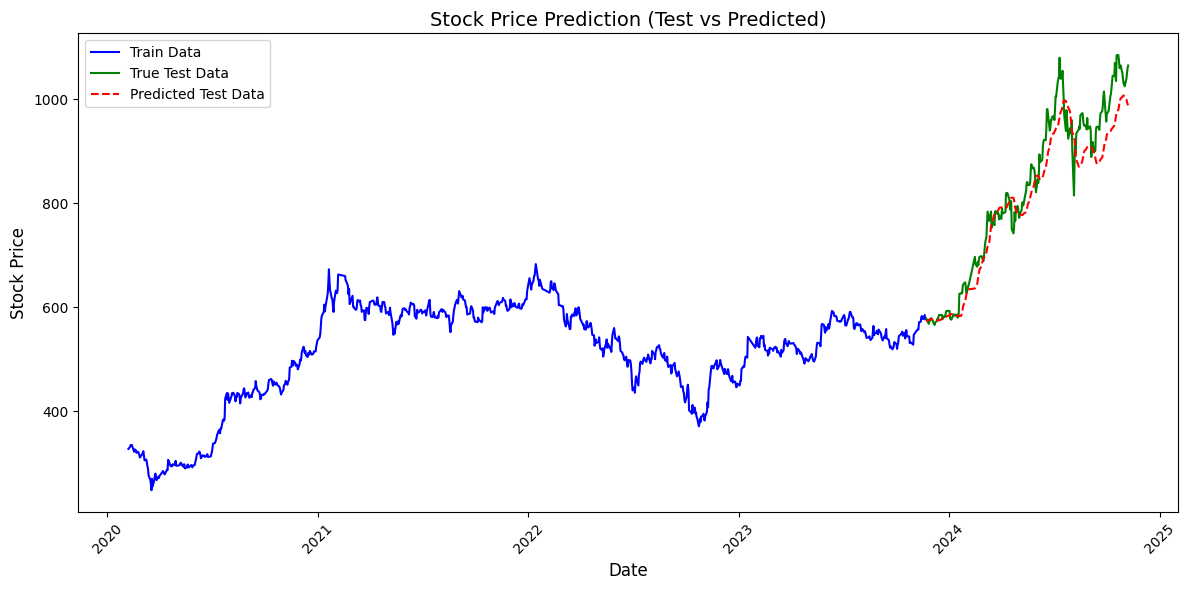

In [68]:
# 假設您的日期資料在 df['Date'] 中
train_dates = df_features.index[:train_size]
test_dates = df_features.index[train_size + 1:]

# 視覺化訓練數據、測試數據和預測數據
plt.figure(figsize=(12, 6))
plt.plot(train_dates, scaler_y.inverse_transform(y_train), label='Train Data', color='blue')  # 訓練數據
plt.plot(test_dates, y_test, label='True Test Data', color='green')  # 真實測試數據
plt.plot(test_dates, y_pred, label='Predicted Test Data', color='red', linestyle='--')  # 預測測試數據

# 標題和標籤
plt.title('Stock Price Prediction (Test vs Predicted)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.legend()

# 顯示圖形
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
